# Self made RP3-beta

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [2]:
class RP3Beta():
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui=train_ui
        self.train_iu=train_ui.transpose()
        
        self.alpha = alpha
        self.beta = beta
        
        # Define Pui 
        Pui=sparse.csr_matrix(self.train_ui/self.train_ui.sum(axis=1))
        
        # Define Piu
        to_divide=np.vectorize(lambda x: x if x>0 else 1)(self.train_iu.sum(axis=1)) # to avoid dividing by zero
        Piu=sparse.csr_matrix(self.train_iu/to_divide)
        item_orders=(self.train_ui>0).sum(axis=0)
        
        Pui = Pui.power(self.alpha)
        Piu = Piu.power(self.alpha)

        P3=Pui*Piu*Pui
        
        P3/=np.power(np.vectorize(lambda x: x if x>0 else 1)(item_orders), self.beta)
        
        self.estimations=np.array(P3)
    
    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [3]:
model=RP3Beta()
model.fit(train_ui, alpha=1, beta=0)

In [4]:
top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_P3_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', index=False, header=False)

In [5]:
import evaluation_measures as ev
estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 4936.65it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.702446  3.527273   0.282185  0.192092  0.186749  0.21698   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.875928  0.181702       0.340803           1.0       0.077201  3.875892   

       Gini  
0  0.974947

# Let's check hiperparameters

##### Alpha

In [6]:
from tqdm import tqdm
result=[]
for alpha in tqdm([round(i,1) for i in np.arange(0.2,1.6001,0.2)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=alpha, beta=0)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 5127.30it/s]
 12%|█▎        | 1/8 [00:18<02:12, 18.88s/it]
0it [00:00, ?it/s]
943it [00:00, 4905.08it/s]
 25%|██▌       | 2/8 [00:37<01:53, 18.91s/it]
0it [00:00, ?it/s]
943it [00:00, 5077.03it/s]
 38%|███▊      | 3/8 [00:56<01:33, 18.75s/it]
0it [00:00, ?it/s]
943it [00:00, 5032.37it/s]
 50%|█████     | 4/8 [01:15<01:15, 18.81s/it]
0it [00:00, ?it/s]
943it [00:00, 5154.37it/s]
 62%|██████▎   | 5/8 [01:34<00:56, 18.88s/it]
0it [00:00, ?it/s]
943it [00:00, 5117.24it/s]
 75%|███████▌  | 6/8 [01:53<00:38, 19.02s/it]
0it [00:00, ?it/s]
943it [00:00, 5012.20it/s]
 88%|████████▊ | 7/8 [02:12<00:18, 18.88s/it]
0it [00:00, ?it/s]
943it [00:00, 5098.59it/s]
100%|██████████| 8/8 [02:30<00:00, 18.83s/it]


Alpha        RMSE         MAE  precision    recall       F_1      F_05  \
0    0.2  268.177832  211.732649   0.262672  0.166858  0.166277  0.197184   
0    0.4   10.546689    7.792373   0.268505  0.172669  0.171569  0.202643   
0    0.6    3.143988    2.948790   0.274655  0.180502  0.177820  0.208730   
0    0.8    3.670728    3.495735   0.281972  0.189868  0.185300  0.216071   
0    1.0    3.702446    3.527273   0.282185  0.192092  0.186749  0.216980   
0    1.2    3.704441    3.529251   0.280912  0.193633  0.187311  0.216872   
0    1.4    3.704580    3.529388   0.273595  0.190651  0.183874  0.212183   
0    1.6    3.704591    3.529399   0.263097  0.186255  0.178709  0.205170   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.187661      0.203252  0.320910  0.196132  0.563378  0.580866   
0         0.192489      0.212653  0.326760  0.200172  0.565148  0.583801   
0         0.198176      0.222746  0.332872  0.203290  0.568872  0.587738   
0         0.203541      0.236751  0.339867  0.206688  0.573729  0.592432   
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.203004      0.240588  0.338049  0.203453  0.571830  0.594313   
0         0.199464      0.239118  0.329550  0.195433  0.566171  0.592793   
0         0.191094      0.232920  0.317439  0.184917  0.552349  0.590545   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.850477  0.159293       0.321247      1.000000       0.060606  3.669627   
0  0.854719  0.164747       0.326323      1.000000       0.064214  3.726996   
0  0.870626  0.171652       0.333140      1.000000       0.065657  3.785282   
0  0.874867  0.179823       0.340076      1.000000       0.070707  3.832415   
0  0.875928  0.181702       0.340803      1.000000       0.077201  3.875892   
0  0.883351  0.182776       0.341341      1.000000       0.085859  3.910718   
0  0.871686  0.179766       0.336190      1.000000       0.107504  3.961915   
0  0.868505  0.175419       0.328868      0.999576       0.156566  4.060156   

       Gini  
0  0.979636  
0  0.978426  
0  0.977090  
0  0.975998  
0  0.974947  
0  0.974073  
0  0.972674  
0  0.969203

IndexError: list index out of range

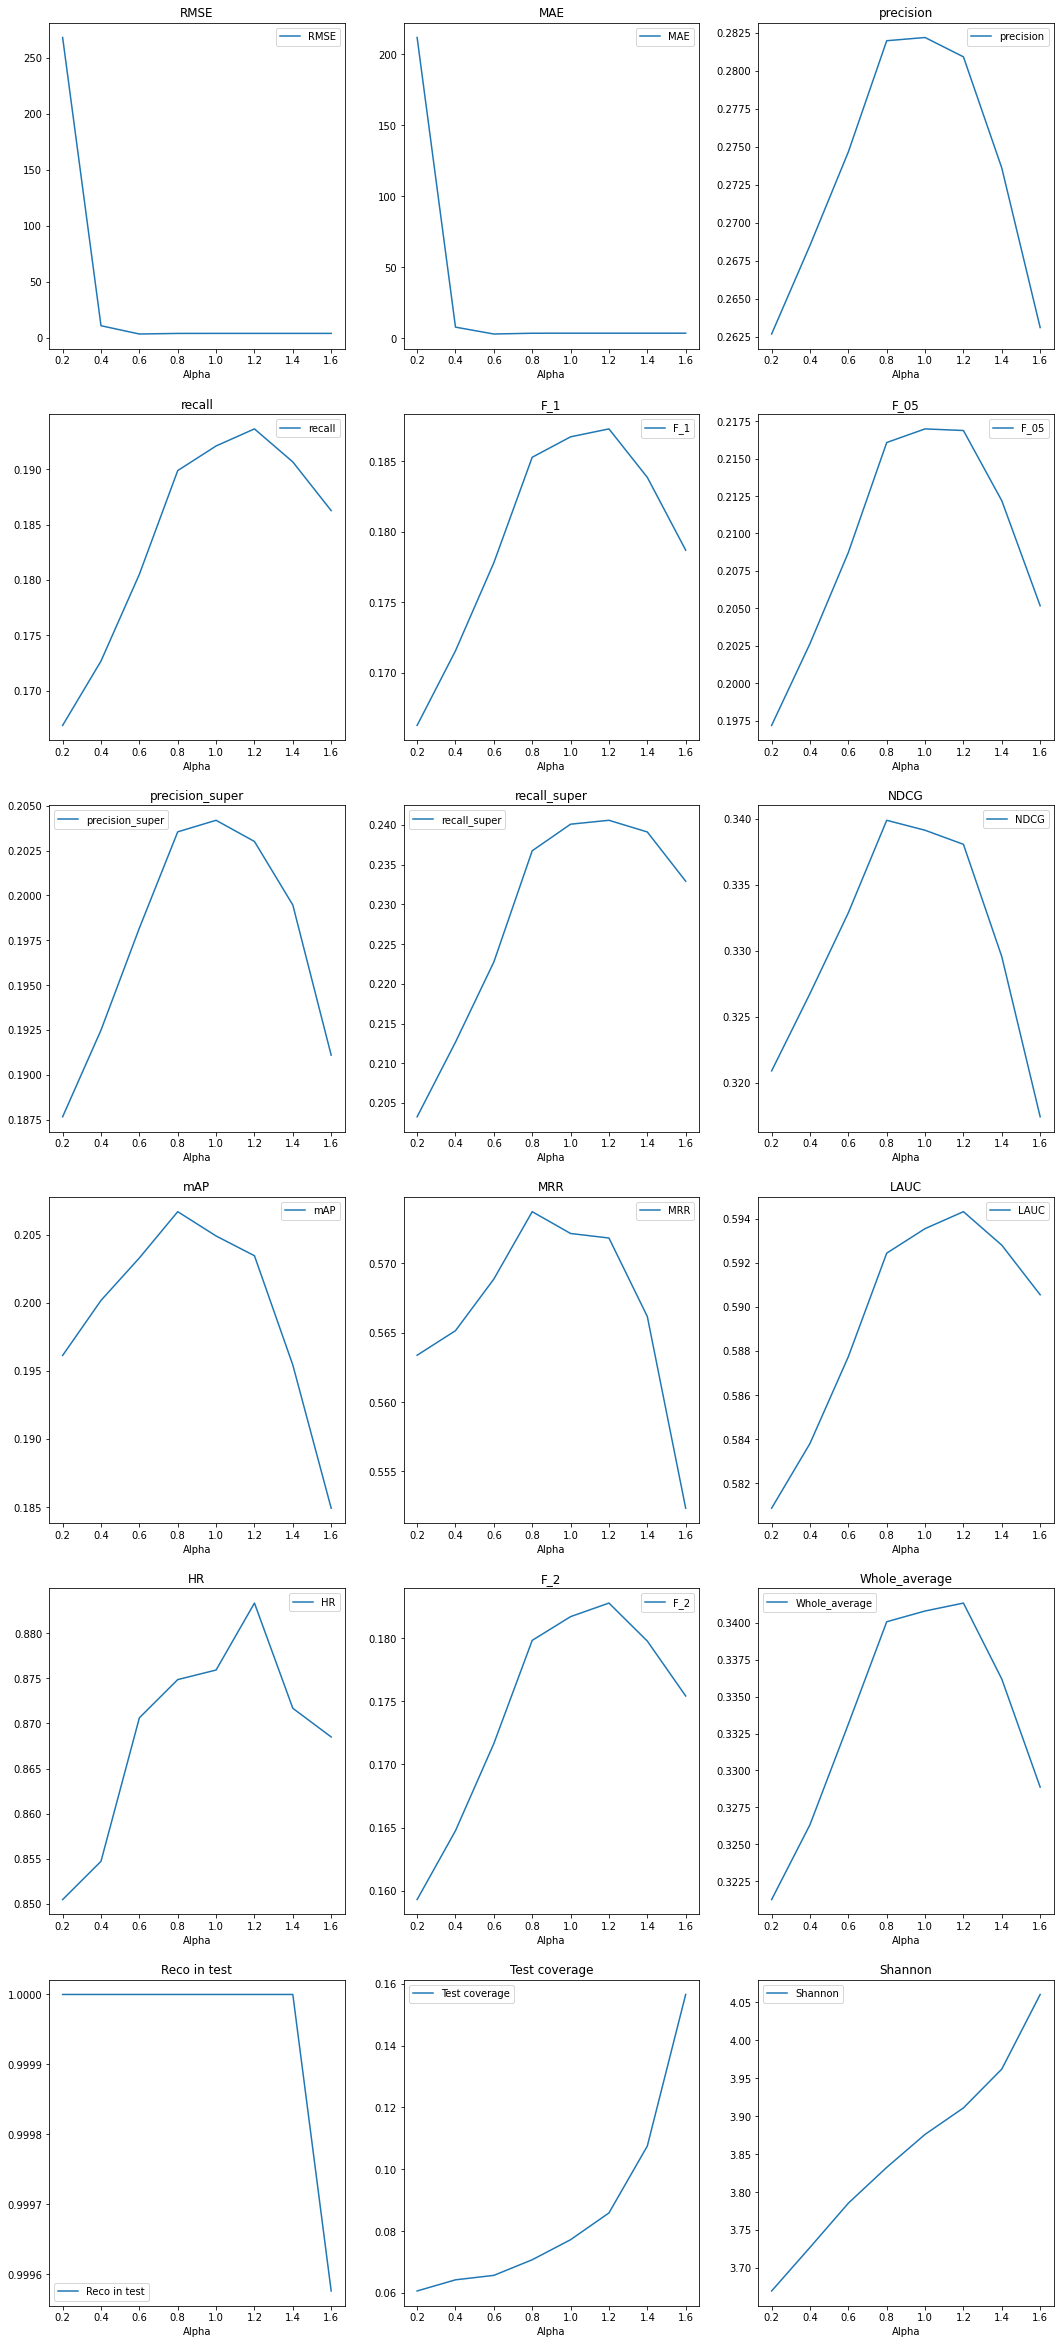

In [8]:
metrics=list(result.columns[[i not in ['Alpha'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Alpha', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

##### Beta

In [9]:
from tqdm import tqdm
result=[]
for beta in tqdm([round(i,1) for i in np.arange(0,1,0.1)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=1, beta=beta)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Beta", beta)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 5110.40it/s]
 10%|█         | 1/10 [00:19<02:58, 19.79s/it]
0it [00:00, ?it/s]
943it [00:00, 5154.22it/s]
 20%|██        | 2/10 [00:39<02:37, 19.71s/it]
0it [00:00, ?it/s]
943it [00:00, 5027.65it/s]
 30%|███       | 3/10 [00:58<02:16, 19.48s/it]
0it [00:00, ?it/s]
943it [00:00, 5020.67it/s]
 40%|████      | 4/10 [01:17<01:55, 19.33s/it]
0it [00:00, ?it/s]
943it [00:00, 4962.05it/s]
 50%|█████     | 5/10 [01:36<01:36, 19.20s/it]
0it [00:00, ?it/s]
943it [00:00, 5076.40it/s]
 60%|██████    | 6/10 [01:54<01:16, 19.01s/it]
0it [00:00, ?it/s]
943it [00:00, 5041.93it/s]
 70%|███████   | 7/10 [02:13<00:56, 18.95s/it]
0it [00:00, ?it/s]
943it [00:00, 5050.76it/s]
 80%|████████  | 8/10 [02:32<00:37, 18.90s/it]
0it [00:00, ?it/s]
458it [00:00, 4577.78it/s]
943it [00:00, 4472.91it/s]
 90%|█████████ | 9/10 [02:51<00:18, 18.91s/it]
0it [00:00, ?it/s]
943it [00:00, 5422.18it/s]
100%|██████████| 10/10 [03:10<00:00, 19.02s/it]


Beta      RMSE       MAE  precision    recall       F_1      F_05  \
0   0.0  3.702446  3.527273   0.282185  0.192092  0.186749  0.216980   
0   0.1  3.703312  3.528128   0.290138  0.197597  0.192259  0.223336   
0   0.2  3.703825  3.528636   0.297137  0.201202  0.196067  0.228169   
0   0.3  3.704130  3.528939   0.303499  0.204749  0.199901  0.232829   
0   0.4  3.704313  3.529120   0.308908  0.208811  0.203854  0.237241   
0   0.5  3.704422  3.529229   0.314316  0.211411  0.206768  0.240986   
0   0.6  3.704488  3.529295   0.314634  0.206209  0.204818  0.240159   
0   0.7  3.704528  3.529335   0.304136  0.187298  0.191990  0.228749   
0   0.8  3.704552  3.529360   0.266384  0.147571  0.158660  0.194838   
0   0.9  3.704567  3.529375   0.162354  0.076967  0.089233  0.114583   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.210944      0.246153  0.347768  0.212034  0.581038  0.596328   
0         0.218026      0.252767  0.355655  0.219909  0.588904  0.598160   
0         0.225107      0.260797  0.363757  0.226825  0.599969  0.599964   
0         0.229614      0.266918  0.370758  0.232673  0.609385  0.602014   
0         0.237124      0.273416  0.378307  0.239297  0.622792  0.603327   
0         0.242489      0.273850  0.376438  0.238428  0.622042  0.600721   
0         0.238305      0.256201  0.358807  0.226808  0.593897  0.591207   
0         0.214485      0.209336  0.299850  0.184356  0.492852  0.571152   
0         0.134657      0.113253  0.160868  0.085486  0.243590  0.535405   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.875928  0.181702       0.340803      1.000000       0.077201  3.875892   
0  0.884411  0.187030       0.347420      1.000000       0.085137  3.957416   
0  0.886532  0.190538       0.352756      1.000000       0.094517  4.053212   
0  0.888653  0.194073       0.358344      1.000000       0.105339  4.147779   
0  0.895016  0.197981       0.363598      0.999894       0.132035  4.259682   
0  0.903499  0.200572       0.369318      0.999046       0.168831  4.411281   
0  0.897137  0.197320       0.367854      0.996394       0.212843  4.621938   
0  0.868505  0.182056       0.352330      0.983033       0.256854  4.898568   
0  0.803818  0.146414       0.307476      0.936373       0.341270  5.257397   
0  0.580064  0.078906       0.197947      0.800106       0.415584  5.563910   

       Gini  
0  0.974947  
0  0.972784  
0  0.969980  
0  0.966948  
0  0.962989  
0  0.956648  
0  0.945932  
0  0.928065  
0  0.895882  
0  0.857396

IndexError: list index out of range

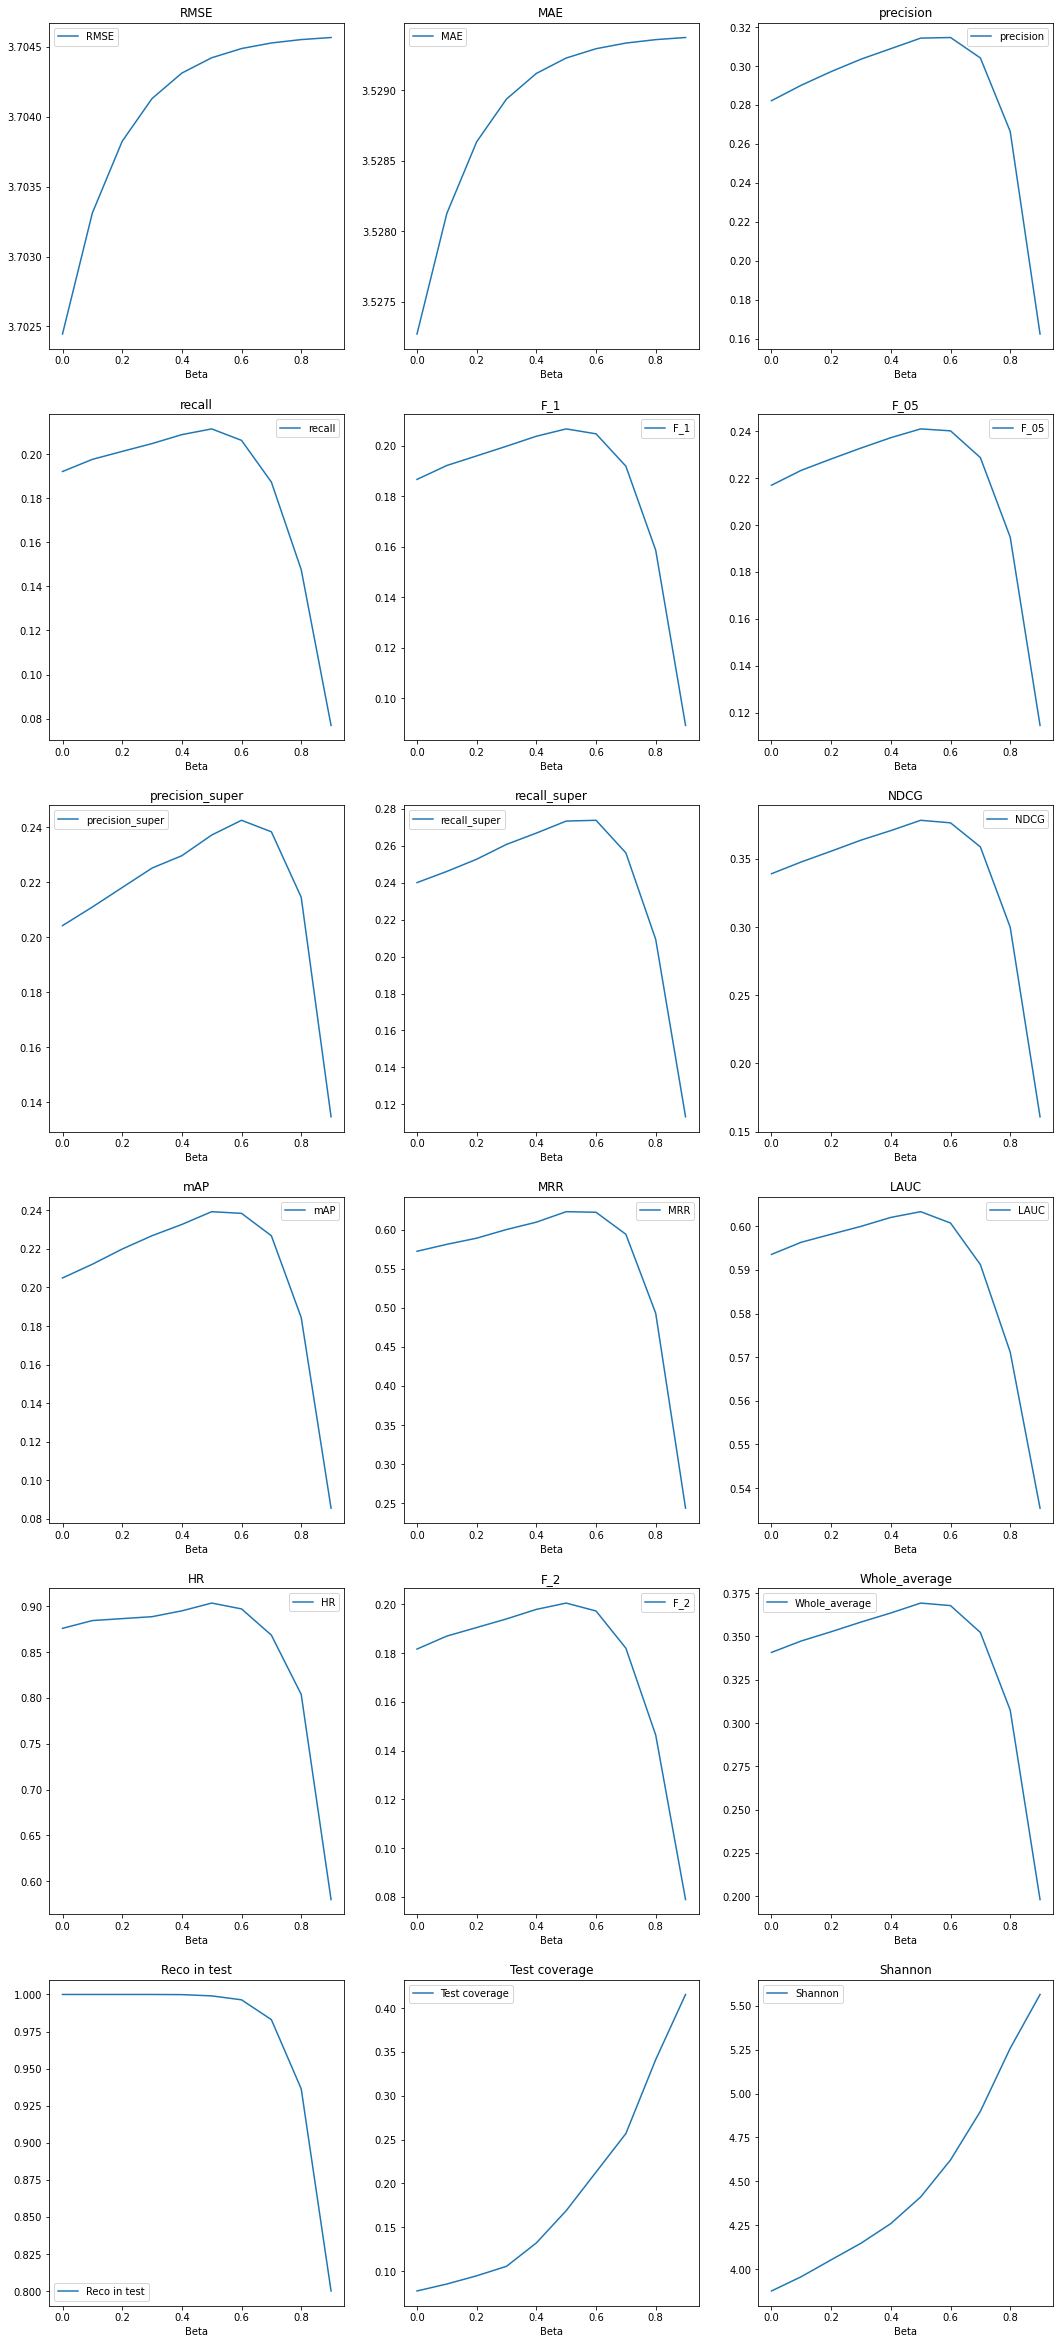

In [10]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Beta'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Beta', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

# Check sample recommendations

In [11]:
train=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

user=random.choice(list(set(train['user'])))

train_content=pd.merge(train, items, left_on='item', right_on='id')
display(train_content[train_content['user']==user][['user', 'rating', 'title', 'genres']]\
        .sort_values(by='rating', ascending=False)[:15])

reco = np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

# Let's ignore scores - they are not used in evaluation: 
reco_users=reco[:,:1]
reco_items=reco[:,1::2]
# Let's put them into one array
reco=np.concatenate((reco_users, reco_items), axis=1)

# Let's rebuild it user-item dataframe
recommended=[]
for row in reco:
    for rec_nb, entry in enumerate(row[1:]):
        recommended.append((row[0], rec_nb+1, entry))
recommended=pd.DataFrame(recommended, columns=['user','rec_nb', 'item'])

recommended_content=pd.merge(recommended, items, left_on='item', right_on='id')
recommended_content[recommended_content['user']==user][['user', 'rec_nb', 'title', 'genres']].sort_values(by='rec_nb')

user  rating                                   title  \
57566   734       5                             Emma (1996)   
50942   734       5            It's a Wonderful Life (1946)   
48429   734       5                          Rebecca (1940)   
22622   734       5                     My Fair Lady (1964)   
22461   734       5              Sound of Music, The (1965)   
35119   734       4           Much Ado About Nothing (1993)   
43403   734       4  Snow White and the Seven Dwarfs (1937)   
2447    734       4               Back to the Future (1985)   
36121   734       4        Silence of the Lambs, The (1991)   
37465   734       4                          Aladdin (1992)   
38209   734       4                     Mary Poppins (1964)   
39918   734       4                      Rear Window (1954)   
40514   734       4                          Titanic (1997)   
42508   734       4                    Jurassic Park (1993)   
45160   734       4              Tomorrow Never Dies (1997)   

                                       genres  
57566                          Drama, Romance  
50942                                   Drama  
48429                       Romance, Thriller  
22622                        Musical, Romance  
22461                                 Musical  
35119                         Comedy, Romance  
43403          Animation, Children's, Musical  
2447                           Comedy, Sci-Fi  
36121                         Drama, Thriller  
37465  Animation, Children's, Comedy, Musical  
38209             Children's, Comedy, Musical  
39918                       Mystery, Thriller  
40514                  Action, Drama, Romance  
42508               Action, Adventure, Sci-Fi  
45160               Action, Romance, Thriller

user  rec_nb                                   title  \
2936  734.0       1               Return of the Jedi (1983)   
7231  734.0       2                            Fargo (1996)   
3322  734.0       3                        Toy Story (1995)   
2519  734.0       4                   Godfather, The (1972)   
5958  734.0       5                          Contact (1997)   
1621  734.0       6                 Schindler's List (1993)   
1248  734.0       7             English Patient, The (1996)   
1455  734.0       8                    Fugitive, The (1993)   
3542  734.0       9                    Jerry Maguire (1996)   
8124  734.0      10  Monty Python and the Holy Grail (1974)   

                                       genres  
2936  Action, Adventure, Romance, Sci-Fi, War  
7231                   Crime, Drama, Thriller  
3322            Animation, Children's, Comedy  
2519                     Action, Crime, Drama  
5958                            Drama, Sci-Fi  
1621                               Drama, War  
1248                      Drama, Romance, War  
1455                         Action, Thriller  
3542                           Drama, Romance  
8124                                   Comedy

# project task 6: generate recommendations of RP3Beta for hiperparameters found to optimize recall

In [12]:
# use better values than (1,0) for alpha and beta
# if you want you can also modify the model to consider different weights (we took as weights user ratings, maybe take ones or squares of ratings instead)
# save the outptut in 'Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_RP3Beta_reco.csv'

## SOLUTION TASK 6

import evaluation_measures as ev

model = RP3Beta()
model.fit(train_ui, alpha = 0.8, beta = 0.6)

top_n = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK = 10))
top_n.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', index = False, header = False)

estimations = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', index = False, header = False)
estimations_df = pd.read_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', header = None)

reco = np.loadtxt('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', delimiter = ',')

ev.evaluate(test = pd.read_csv('./Datasets/ml-100k/test.csv', sep = '\t', header = None),
            estimations_df = estimations_df, 
            reco = reco,
            super_reactions = [4, 5])

943it [00:00, 4555.12it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  3.702928  3.527713   0.322694  0.216069  0.212152  0.247538   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.245279      0.284983  0.388271  0.248239  0.636318  0.605683   

         HR      F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.910923  0.20545       0.376967      0.999788       0.178932  4.549663   

       Gini  
0  0.950182

In [13]:
result.sort_values(["recall"])

Beta      RMSE       MAE  precision    recall       F_1      F_05  \
0   0.9  3.704567  3.529375   0.162354  0.076967  0.089233  0.114583   
0   0.8  3.704552  3.529360   0.266384  0.147571  0.158660  0.194838   
0   0.7  3.704528  3.529335   0.304136  0.187298  0.191990  0.228749   
0   0.0  3.702446  3.527273   0.282185  0.192092  0.186749  0.216980   
0   0.1  3.703312  3.528128   0.290138  0.197597  0.192259  0.223336   
0   0.2  3.703825  3.528636   0.297137  0.201202  0.196067  0.228169   
0   0.3  3.704130  3.528939   0.303499  0.204749  0.199901  0.232829   
0   0.6  3.704488  3.529295   0.314634  0.206209  0.204818  0.240159   
0   0.4  3.704313  3.529120   0.308908  0.208811  0.203854  0.237241   
0   0.5  3.704422  3.529229   0.314316  0.211411  0.206768  0.240986   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.134657      0.113253  0.160868  0.085486  0.243590  0.535405   
0         0.214485      0.209336  0.299850  0.184356  0.492852  0.571152   
0         0.238305      0.256201  0.358807  0.226808  0.593897  0.591207   
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.210944      0.246153  0.347768  0.212034  0.581038  0.596328   
0         0.218026      0.252767  0.355655  0.219909  0.588904  0.598160   
0         0.225107      0.260797  0.363757  0.226825  0.599969  0.599964   
0         0.242489      0.273850  0.376438  0.238428  0.622042  0.600721   
0         0.229614      0.266918  0.370758  0.232673  0.609385  0.602014   
0         0.237124      0.273416  0.378307  0.239297  0.622792  0.603327   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.580064  0.078906       0.197947      0.800106       0.415584  5.563910   
0  0.803818  0.146414       0.307476      0.936373       0.341270  5.257397   
0  0.868505  0.182056       0.352330      0.983033       0.256854  4.898568   
0  0.875928  0.181702       0.340803      1.000000       0.077201  3.875892   
0  0.884411  0.187030       0.347420      1.000000       0.085137  3.957416   
0  0.886532  0.190538       0.352756      1.000000       0.094517  4.053212   
0  0.888653  0.194073       0.358344      1.000000       0.105339  4.147779   
0  0.897137  0.197320       0.367854      0.996394       0.212843  4.621938   
0  0.895016  0.197981       0.363598      0.999894       0.132035  4.259682   
0  0.903499  0.200572       0.369318      0.999046       0.168831  4.411281   

       Gini  
0  0.857396  
0  0.895882  
0  0.928065  
0  0.974947  
0  0.972784  
0  0.969980  
0  0.966948  
0  0.945932  
0  0.962989  
0  0.956648

In [14]:
model=RP3Beta()
model.fit(train_ui, alpha=0.8, beta=0.6)
reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
reco.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', index=False, header=False)
estimations_df.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', index=False, header=False)

In [15]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 5460.13it/s]
943it [00:00, 4803.05it/s]
943it [00:00, 5055.06it/s]
943it [00:00, 5345.09it/s]
943it [00:00, 5630.17it/s]
943it [00:00, 5312.63it/s]
943it [00:00, 5254.57it/s]
943it [00:00, 5601.35it/s]
943it [00:00, 4720.28it/s]
943it [00:00, 5849.34it/s]
943it [00:00, 3628.59it/s]
943it [00:00, 4575.68it/s]
943it [00:00, 5025.63it/s]
943it [00:00, 4779.84it/s]
943it [00:00, 4822.16it/s]
943it [00:00, 4399.16it/s]
943it [00:00, 4856.83it/s]
943it [00:00, 4987.44it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0          Self_RP3Beta  3.702928  3.527713   0.322694  0.216069  0.212152   
0               Self_P3  3.702446  3.527273   0.282185  0.192092  0.186749   
0           Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0      Self_SVDBaseline  3.642359  3.476956   0.135949  0.079751  0.082423   
0             Ready_SVD  0.951186  0.750553   0.094910  0.044564  0.051182   
0              Self_SVD  0.914024  0.717181   0.104454  0.043836  0.053331   
0        Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0       Ready_SVDBiased  0.939359  0.740564   0.086850  0.036359  0.043933   
0  Self_KNNSurprisetask  0.946255  0.745209   0.083457  0.032848  0.041227   
0         Self_TopRated  2.508258  2.217909   0.079321  0.032667  0.039983   
0        Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0          Ready_Random  1.525633  1.225714   0.047720  0.022049  0.025494   
0           Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0   Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0           Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0       Self_BaselineIU  0.958136  0.754051   0.000954  0.000188  0.000298   
0       Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0             Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.247538         0.245279      0.284983  0.388271  0.248239  0.636318   
0  0.216980         0.204185      0.240096  0.339114  0.204905  0.572157   
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.099673         0.106545      0.104164  0.160100  0.079313  0.328798   
0  0.065639         0.084549      0.074410  0.106164  0.049263  0.228326   
0  0.070716         0.094528      0.076751  0.106711  0.050532  0.194366   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.058123         0.076395      0.056913  0.094528  0.043830  0.203204   
0  0.055493         0.074785      0.048890  0.089577  0.040902  0.189057   
0  0.053170         0.068884      0.048582  0.070766  0.027602  0.114790   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.032845         0.029077      0.025015  0.051757  0.019242  0.128181   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       F_2  Whole_average  Reco in test  Test coverage  \
0  0.605683  0.910923  0.205450       0.376967      0.999788       0.178932   
0  0.593544  0.875928  0.181702       0.340803      1.000000       0.077201   
0  0.555546  0.765642  0.112750       0.249607      1.000000       0.038961   
0  0.536764  0.629905  0.077617       0.201750      1.000000       0.282828   
0  0.518988  0.477200  0.045601       0.153400      0.996925       0.219336   
0  0.518647  0.479321  0.045941       0.153261      0.853765       0.148629   
0  0.515501  0.437964  0.039549       0.141900      1.000000       0.033911   
0  0.514846  0.443266  0.038036       0.141357      0.994804       0.179654   
0  0.513076  0.417815  0.034996       0.135177      0.888547       0.130592   
0  0.512943  0.411453  0.034385       0.124546      1.000000       0.024531   
0  0.509546  0.384942  0.027213       0.118383      1.000000       0.025974   
0  0.507543  0.327678  0.022628       0.103269      0.987275       0.184704   
0  0.499885  0.154825  0.008007       0.069521      0.402333   

# project task 7 (optional): implement graph-based model of your choice 

In [16]:
# for example change length of paths in RP3beta
# save the outptut in 'Recommendations generated/ml-100k/Self_GraphTask_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_GraphTask_reco.csv'